In [79]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from itertools import combinations
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

In [80]:
stock_prices = pd.read_pickle('all_prices.pkl')[1:]
comm_prices = pd.read_pickle('commodities_price.pkl')[2:]
stock_prices.index = pd.to_datetime(stock_prices.index)
stock_prices.index = stock_prices.index.date
comm_prices.index = pd.to_datetime(comm_prices['px_last'])
comm_prices.drop(columns=['px_last'], inplace=True)
comm_prices.index = comm_prices.index.date

In [81]:
merged_df = pd.merge(stock_prices, comm_prices, right_index = True, left_index = True, how='inner')
na_str = merged_df['HWTK4 Comdty'].iloc[1]
merged_df.replace(na_str, np.nan, inplace=True)
merged_df.dropna(axis=1, inplace=True)
merged_df.head(3)
prices=merged_df
stocks = []
comms = []
for asset in list(prices.columns):
    if asset in list(stock_prices.columns):
        stocks.append(asset)
    elif asset in list(comm_prices.columns):
        comms.append(asset)
returns = np.log1p(prices.pct_change()).dropna()
prices = prices[1:]

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/1332536027.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/ommehta/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log1p



In [82]:
def reduce_and_test_cointegration(returns, stocks, comms, sample_size=200, corr_threshold=0.5):
    # Filter stocks and commodities from returns DataFrame
    # Calculate the correlation matrix and select stocks with high correlation

    corr_matrix = returns.corr()

    high_corr_pairs = [(_stock, comm) for _stock in stocks for comm in comms
                       if corr_matrix.at[_stock, comm] > corr_threshold and _stock != comm] #extract out a list of tuples––all pairs w/ ≥ 0.6 corr 
    # Randomly sample pairs if there are too many
    if len(high_corr_pairs) > sample_size:
        indices = np.random.choice(len(high_corr_pairs), size=sample_size, replace=False)
        high_corr_pairs = [high_corr_pairs[i] for i in indices]

    # Perform the cointegration}
    cointegration_results = {}
    for stock, comm in high_corr_pairs:
        score, pvalue, _ = coint(returns[stock], returns[comm])
        cointegration_results[(stock, comm)] = score

    # Get top 10 cointegrated pairs
    sorted_pairs = sorted(cointegration_results.items(), key=lambda x: x[1])
    top_10_cointegrated = {pair: score for pair, score in sorted_pairs[:40]}

    return top_10_cointegrated


In [83]:
def get_most_coint(asset1, asset2):
    return list(reduce_and_test_cointegration(returns, asset1, asset2).keys())
    
stocks_stocks = get_most_coint(stocks, stocks)
stocks_comms = get_most_coint(stocks, comms)
comms_comms = get_most_coint(comms, comms)

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/3199259538.py:17: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/3199259538.py:17: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/3199259538.py:17: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/3199259538.py:17: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



In [86]:
def pair_trading(prices_df, returns_df, pairs):

    starting_capital = 100000 
    transaction_costs = 0.005
    iteration = 0
    portfolio = {}
    cash_balance = starting_capital
    open_positions = {}
    port_value = {}

    for stock, comm in pairs:

        portfolio[stock] = 0
        portfolio[comm] = 0
    
    for date in prices_df.index:

        for pair in pairs:
            stock, comm = pair
            threshold = int(len(prices_df)*0.7)
            spread_series = np.log(prices_df[stock][0:threshold]) - np.log(prices_df[comm][0:threshold])
            mu = np.mean(spread_series)
            sigma = np.std(spread_series)

            if date in prices_df.index and stock in prices_df.columns and comm in prices_df.columns and date in returns_df.index:
                
                if iteration <= threshold:
                    continue
                stock_price, stock_ret = prices_df.at[date, stock], returns_df.at[date, stock]
                comm_price, comm_ret = prices_df.at[date, comm], returns_df.at[date, comm]
                CURRENT_SPREAD = np.log(stock_price) - np.log(comm_price)

                z = (CURRENT_SPREAD-mu)/sigma

                if abs(z) > 2:  # If z-score exceeds 2, enter a position

                    if z > 2:
                        if pair not in open_positions:
                            if portfolio[stock] == 0 and portfolio[comm] == 0:
                                portfolio[stock] = -(cash_balance*0.1)/stock_price
                                portfolio[comm] = (cash_balance*0.1)/comm_price
                                cash_balance = cash_balance - portfolio[stock] * stock_price - portfolio[comm] * comm_price 
                                open_positions[pair] = date  # Record entry date


                    elif z < -2:
                        if pair not in open_positions:
                            if portfolio[stock] == 0 and portfolio[comm] == 0:
                                portfolio[stock] = (cash_balance*0.1)/stock_price
                                portfolio[comm] = -(cash_balance*0.1)/comm_price
                                cash_balance = cash_balance - portfolio[stock] * stock_price - portfolio[comm] * comm_price 
                                open_positions[pair] = date 


                if abs(z) < 0.5 or date == datetime.date(2024, 4, 17):  # If z-score falls below 0.5, or last day of period, exit position

                    if pair in open_positions:
                        if portfolio[stock] < 0 and portfolio[comm] > 0:
                            cash_balance += (portfolio[stock] * stock_price + portfolio[comm] * comm_price)*(1-transaction_costs)  # Add total revenue
                            portfolio[stock] = 0
                            portfolio[comm] = 0
                            entry_date = open_positions.pop(pair)
                        else:
                            cash_balance += (portfolio[stock] * stock_price + portfolio[comm] * comm_price)*(1-transaction_costs)  # Add total revenue
                            portfolio[stock] = 0
                            portfolio[comm] = 0
                            entry_date = open_positions.pop(pair)
        iteration += 1
        port_value[date] = cash_balance
        for key, value in portfolio.items():
            port_value[date] += value * prices_df.at[date, key]

    return cash_balance, port_value

In [87]:
portfolio_stocks_stocks = pair_trading(prices, returns, stocks_stocks)[1]
portfolio_stocks_comms = pair_trading(prices, returns, stocks_comms)[1]
portfolio_comms_comms = pair_trading(prices, returns, comms_comms)[1]

/Users/ommehta/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/2772347354.py:33: RuntimeWarning:

invalid value encountered in scalar divide



In [41]:
def run_metrics(prices):
    df = {}
    rf = 0.05
    returns = np.log1p(prices.pct_change()).dropna()
    monthly_mean = np.mean(returns)*21
    annualized_mean = np.mean(returns)*252
    annualized_std = np.std(returns)*np.sqrt(252)
    annualized_downside = np.std([i for i in returns if i < 0]) * np.sqrt(252)
    monthly_vol = np.std(returns)*np.sqrt(21)
    sharpe = (annualized_mean - rf)/annualized_std
    sortino = (annualized_mean - rf)/annualized_downside
    bottom_5 = int(0.05*len(returns))
    var = np.mean((sorted(returns)[0:bottom_5])) * 21
    df['Monthly Return'] = monthly_mean
    df['Monthly Volatility'] = monthly_vol
    df['Sharpe'] = sharpe
    df['Sortino'] = sortino
    df['95% VaR'] = var
    
    df = pd.DataFrame([df])
    return df

In [50]:
final_df = pd.DataFrame()
spy = yf.download('SPY', '2013-01-03', '2024-04-17', progress=False)['Adj Close']
final_df['SPY'] = spy * 841.3773394291766 #this is the amount of shares to make it a $100000 investment at t=0
final_df['Stock & Stock'] = list(portfolio_stocks_stocks.values())
final_df['Stock & Comm'] = list(portfolio_stocks_comms.values())
final_df['Comm & Comm'] = list(portfolio_comms_comms.values())

In [43]:
spy_metrics = run_metrics(final_df['SPY'])
port_metrics = run_metrics(final_df['Stock & Comm'])

In [44]:
spy_metrics

,Monthly Return,Monthly Volatility,Sharpe,Sortino,95% VaR
0,0.010679,0.048962,0.460783,0.545408,-0.55456


In [74]:
port_metrics['Sharpe'].iloc[0]

0.5392922748889925

In [88]:
spy_ret = np.log1p(final_df['SPY'].pct_change()).dropna()
#port_ret = np.log1p(final_df['Stock & Stock'].pct_change()).dropna()
#port_ret = np.log1p(final_df['Stock & Comm'].pct_change()).dropna()
port_ret = np.log1p(final_df['Comm & Comm'].pct_change()).dropna()
beta = (np.cov(spy_ret, port_ret)/np.var(spy_ret))[0, 1]
beta

-0.07724650778965837

In [90]:
#Gross (or net) return
(final_df['Comm & Comm'][-1]-final_df['Comm & Comm'][0])/final_df['Comm & Comm'][0]

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/1090858027.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



1.6454030018606915

In [91]:
#Alpha
rf = 0.05
e_rp = rf + beta * (np.mean(spy_ret)*252 - rf)
a_rp = np.mean(port_ret)*252
alpha = a_rp - e_rp
alpha

0.042388420510354526

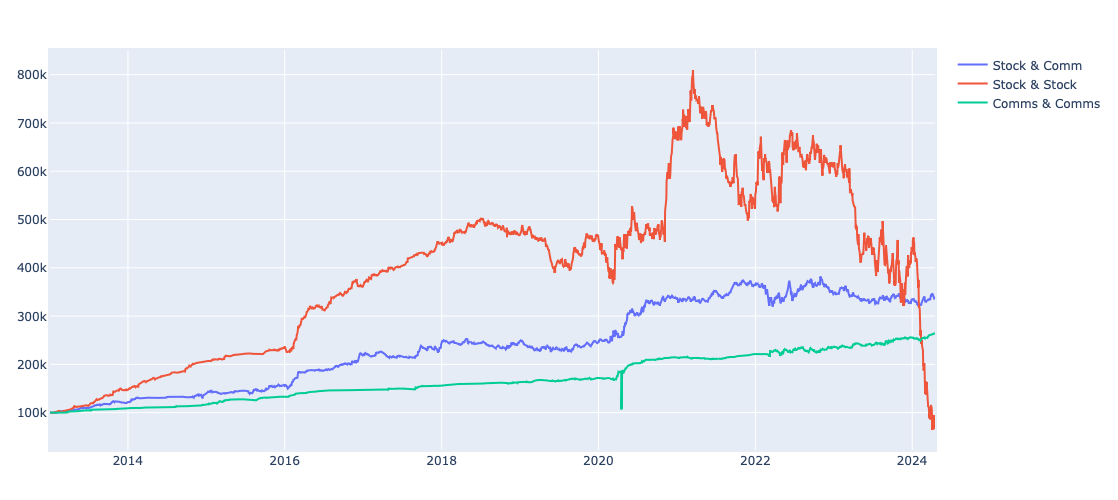

In [64]:
import plotly.graph_objects as go

trace1 = go.Scatter(
    x=final_df.index,
    y=final_df['Stock & Comm'],
    mode='lines',
    name='Stock & Comm'
)

trace2 = go.Scatter(
    x=final_df.index,
    y=final_df['Stock & Stock'],
    mode='lines',
    name='Stock & Stock'
)
trace3 = go.Scatter(
    x=final_df.index,
    y=final_df['Comm & Comm'],
    mode='lines',
    name='Comms & Comms'
)

# Create the figure object
fig = go.Figure(data=[trace1, trace2, trace3])

# Update layout for aspect ratio
fig.update_layout(
    # Other layout properties
    autosize=False,
    width=1000,  # You can increase this for a wider graph
    height=500,  # Adjust the height as needed
    margin=dict(l=50, r=50, b=50, t=50, pad=2),
    # ...
)

# Make the lines thinner by updating traces
fig.update_traces(line=dict(width=2))  # Decrease the width value for thinner lines

# Show the plot
fig.show()

In [77]:
import numpy as np

# Define a range of window sizes to test
window_sizes_to_test = range(0, 1000, 50)  # Example range

# Initialize variables to store the optimal window size and corresponding cash balance
optimal_window_size = None
max_sharpe = float('-inf')

for window_size in window_sizes_to_test:
    
    portfolio = pair_trading(prices, returns, stocks_comms, window_size)[1]
    sharpe = run_metrics(pd.Series(list(portfolio_stocks_stocks.values())))['Sharpe'].iloc[0]
    if sharpe > max_sharpe:
        max_sharpe = sharpe
        optimal_window_size = window_size

print(f'Optimal size {optimal_window_size}, sharpe {max_sharpe}')

/var/folders/q1/n178rnzj65bdl86f8t6tlscc0000gq/T/ipykernel_18118/3709211059.py:38: RuntimeWarning:

divide by zero encountered in scalar divide



Optimal size 0, sharpe -0.15084015372121687
